# Visualisation Generation

Follow the steps below to create your visualisations:

1. Upload a graphml file into the 'files/graphs/' folder of this library.
2. Edit the 'graphml_file' variable below to match the name of your file.
3. Run all the cells. The svg will be output below and saved to the files 'files/svg/' folder in this library.

## Things you can tweak

- You can change the size of the output image by changing the 'size' argument (it needs to be a floating point number, so if you want your visualisation twice the size, change it to 2.0).
- If your visualisation is too small relative to the size of the image, or overflows the boundaries, tweak the 'scale_correction' argument in increments +- 100
- Change the 'curved' argument to True to add curved connections
- Tweak the position of the labels up and down by adjusting 'label_correction' between 0.1 and 1.0
- Tweak the size of the nodes relative the image using node_scale - int or float values between 0.5 and 5 tend to work okay
- You can add a background image by uploading an .svg to the 'background_svgs' folder and editing the 'colour_style' dictionary above - more details if you scroll up!
- By default, the graph is centred on the background - this might not look right if you have a background image. Pass a tuple of (x, y) values (eg. (120, 100)) to offset the graph relative to the backround.

## Viewing and Downloading your Visualisation

You can download your image from the 'files/svg/' folder. Your computer will probably try to open the file in a text editor; don't do this - open it in a web browser instead.

## Errors

If the script breaks, the most likely cause is your nodes are too close together - the solution is to tweak your graph layout in Gephi, and is more likely to be triggered if you have the 'curved' argument set to 'True'.

In [1]:
from styles import print_style, colour_style
from visualisation_generators import SvgGrapher
from IPython.display import display_svg, SVG

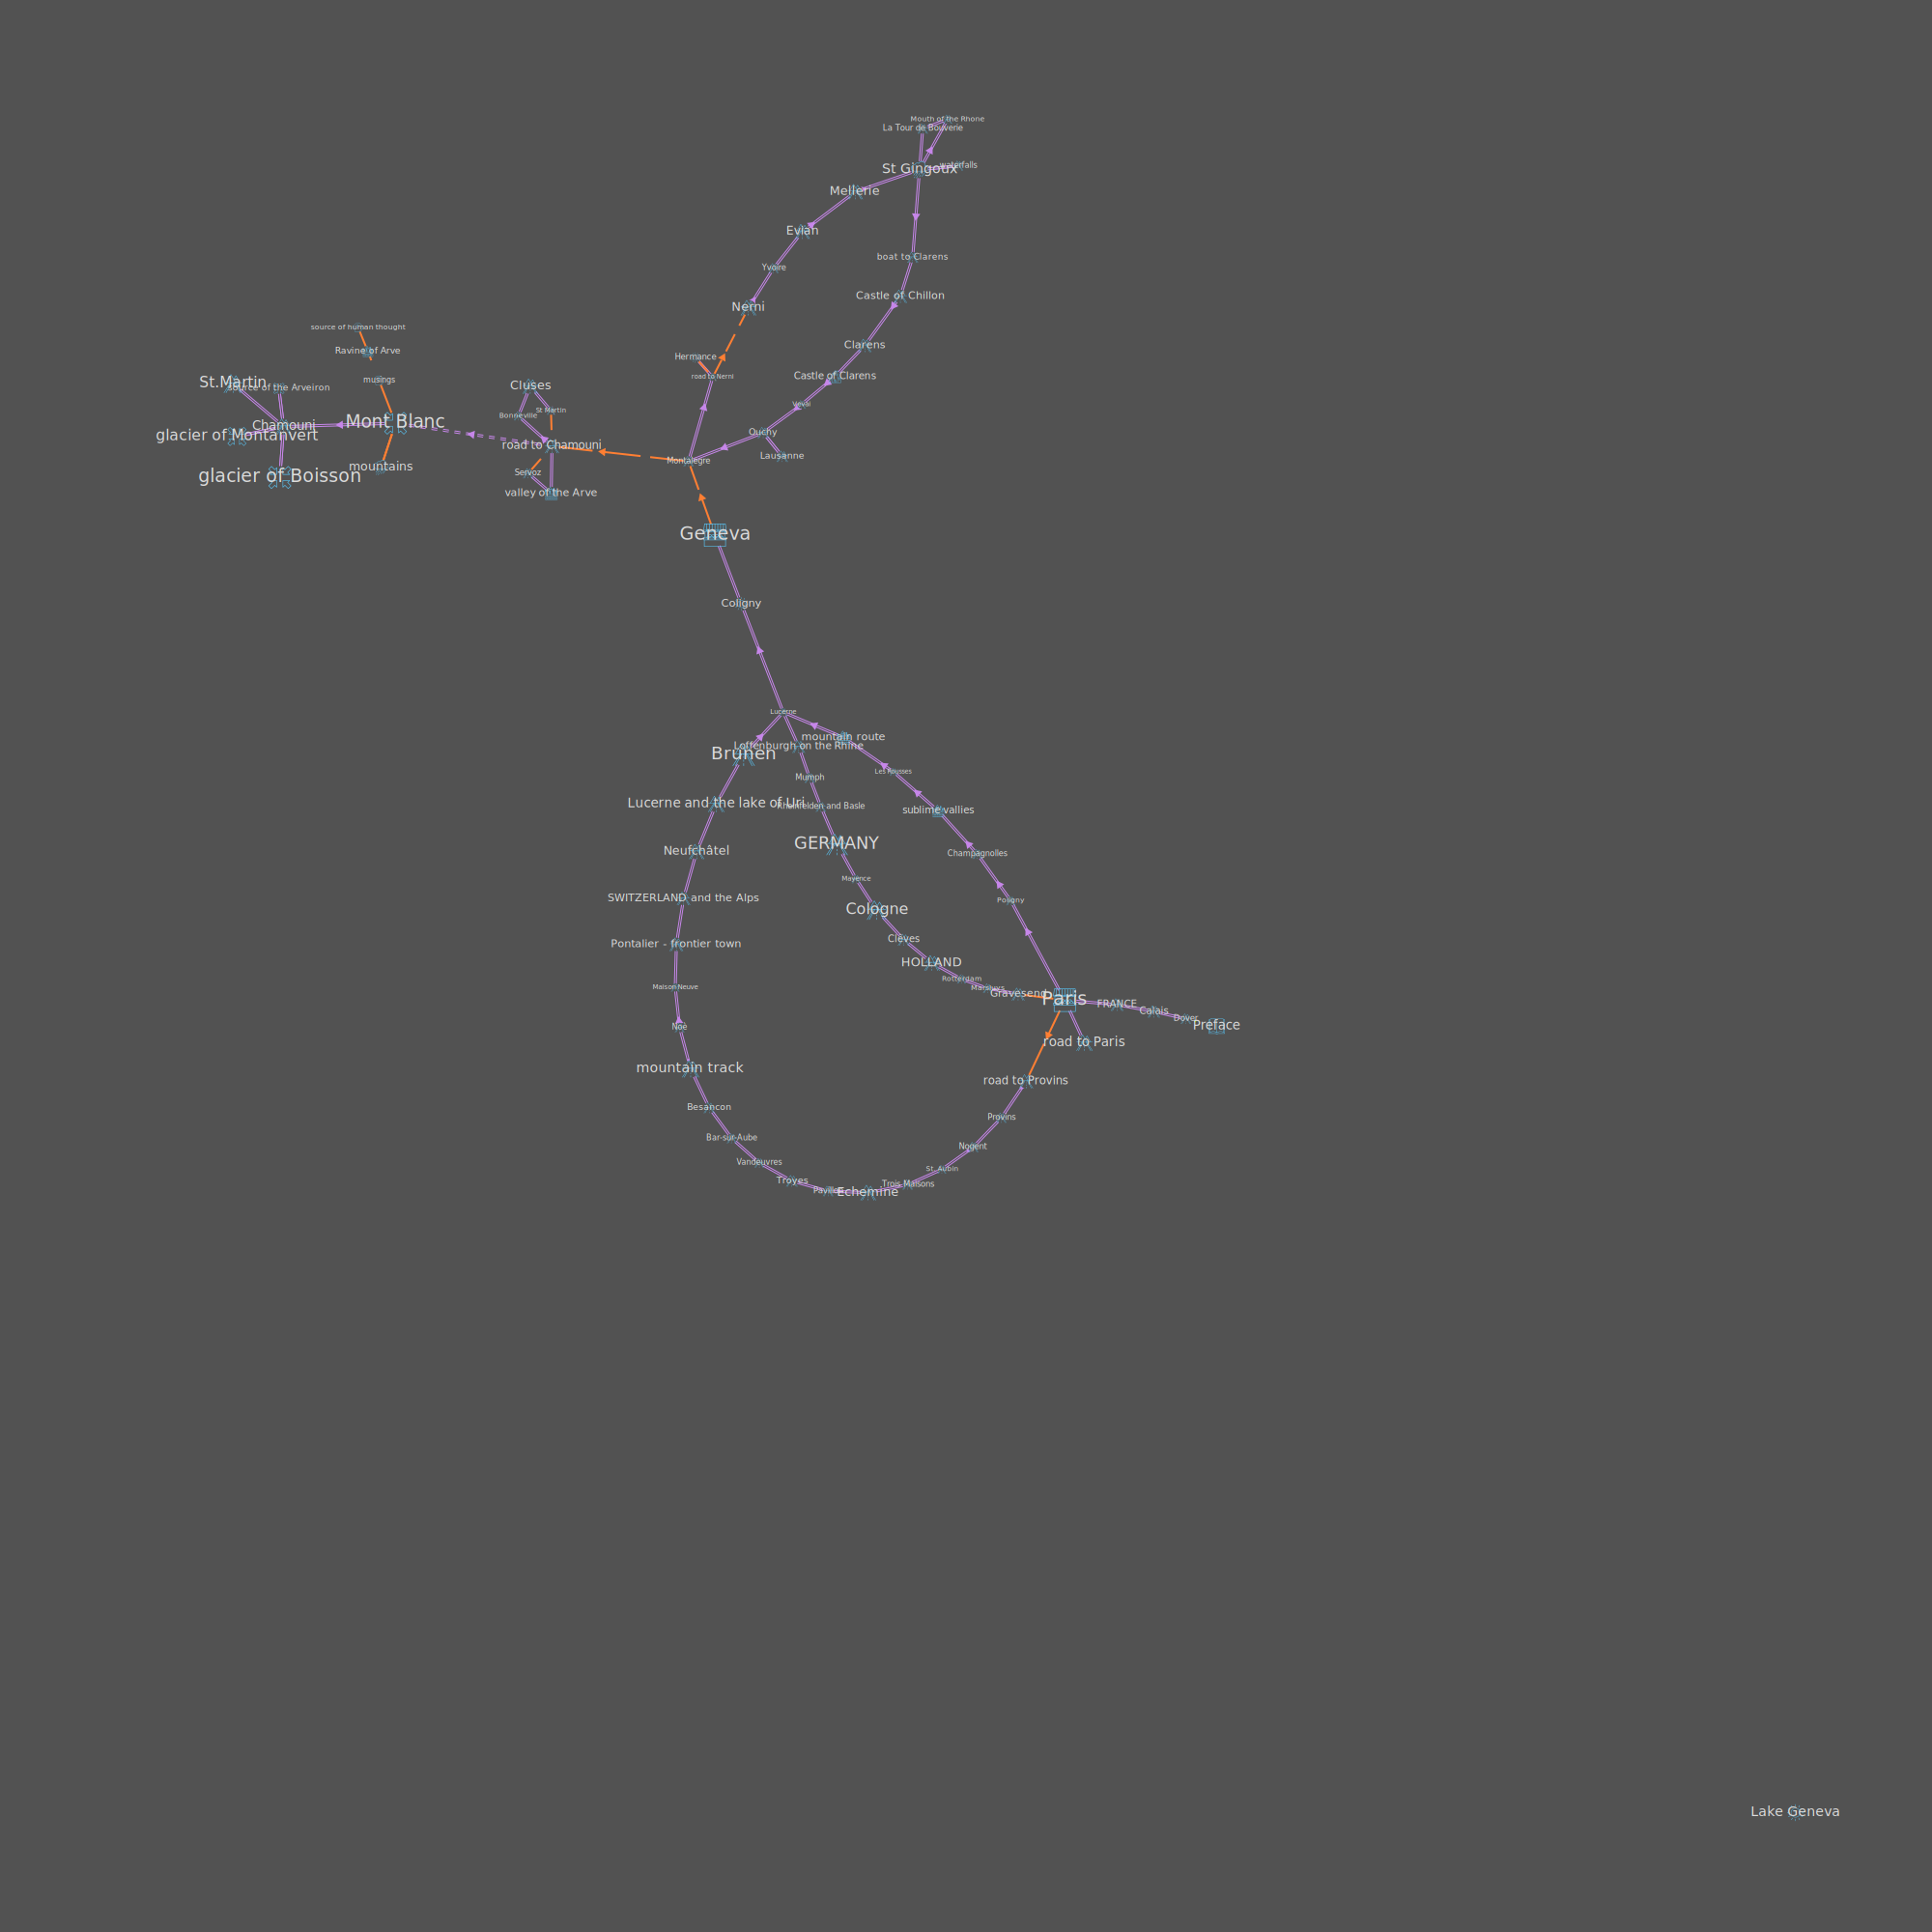

In [6]:
graphml_file = 'Shelley-Tour_full-topoi.graphml'

svg_file = graphml_file.replace('graphml', 'svg')

visualisation = SvgGrapher('files/graphs/' + graphml_file)

visualisation.draw_graph('files/svg/' + svg_file, style=colour_style, size=1, scale_correction=570, curved=False, label_correction=0.8, node_scale=0.8, offset=(0,0))

# Display the graph
display_svg(SVG('files/svg/' + svg_file))